## Extracting Leaf Traits from 3D data

### Last edited: M. Jenkins
### 03.16.18

In [1]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np
import scipy
import skimage
from skimage import io
from skimage.transform import rescale
from skimage.morphology import remove_small_objects, skeletonize_3d, medial_axis
from skimage.measure import marching_cubes_lewiner, mesh_surface_area
from scipy.ndimage.morphology import distance_transform_edt
from scipy.ndimage.filters import maximum_filter, median_filter, minimum_filter, percentile_filter

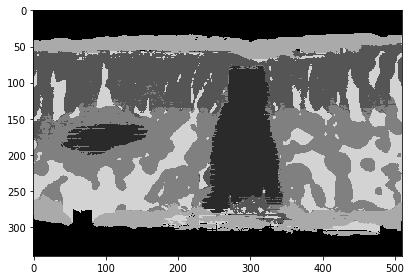

In [3]:
# Import full stack prediction from ML algorithm
# filepath = '../../../ML_microCT/results/'
filepath = '../results/'
results_folder = 'monticola4'
img = io.imread(filepath+results_folder+'/post_processed_fullstack.tif')
io.imshow(img[65,:,:])
io.show()

In [4]:
# define pixel values
epidermis = 170
spongy = 128
palisade = 85
ias = 212
bg = 0
vein = 42

In [5]:
# Define 3D array of distances from lowest value img.shape[1] to highest values
a = range(0,img.shape[1])
b = np.tile(a,(img.shape[2],img.shape[0],1))
b = np.moveaxis(b,[0,1,2],[2,0,1])

# Define 3D array of distances from lower value of img.shape[1] to median value
rangeA = range(0,img.shape[1]/2)
tileA = np.tile(rangeA,(img.shape[2],img.shape[0],1))
tileA = np.moveaxis(tileA,[0,1,2],[2,0,1])

# Define 3D array of distances from upper value of image.shape[1] to median value
rangeB = range(img.shape[1]/2,img.shape[1])
tileB = np.tile(rangeB,(img.shape[2],img.shape[0],1))
tileB = np.moveaxis(tileB,[0,1,2],[2,0,1])
tileB = np.flip(tileB,1)

/Users/mattjenkins1/anaconda2/lib/python2.7/site-packages/skimage/io/_plugins/matplotlib_plugin.py:74: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


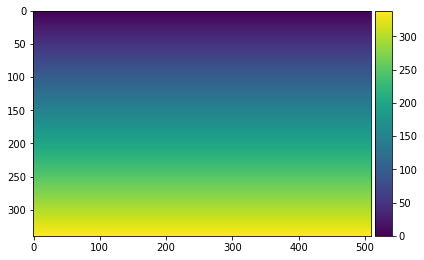

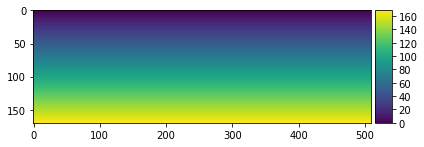

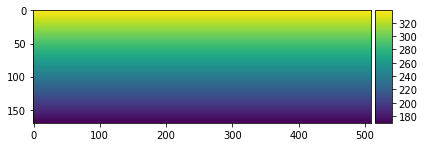

In [6]:
%matplotlib inline
io.imshow(b[0,:,:])
io.show()
io.imshow(tileA[0,:,:])
io.show()
io.imshow(tileB[0,:,:])
io.show()

In [7]:
hold = img.shape[1]/2
img2 = np.array(img, copy=True)
imgconc1 = np.array(img[:,0:hold,:], copy = True) 
imgconc2 = np.array(img[:,hold:img.shape[1],:], copy = True)

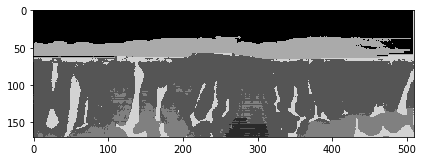

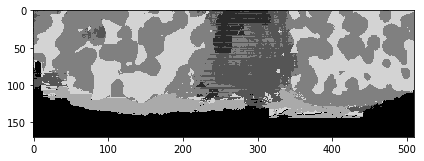

In [8]:
%matplotlib inline
io.imshow(imgconc1[0,:,:])
io.show()
io.imshow(imgconc2[0,:,:])
io.show()

In [16]:
# Determine the upper edge of the palisade mesophyll
c = (imgconc1==palisade)
d = (tileA*c)
p_low_in = np.argmin(d, axis=1)
        
# Determine the upper edge of ias
c = (imgconc1==ias)
d = (tileA*c)
ias_low_in = np.argmin(d, axis=1)   

# Determine the inner edge of the upper epidermis
c = (imgconc1==epidermis)
d = (tileA*c)
e_low_in = np.argmax(d, axis=1)

e_low_in = np.maximum(e_low_in, p_low_in) # Checks if mesophyll cells are below lower epidermis
                                 # Changes mesophyll pixel to epidermal class
e_low_in = np.maximum(e_low_in, ias_low_in) # Similar to above, but with ias

epi_low_in = np.zeros(img.shape)
for z in range(0,epi_low_in.shape[0]):
    for x in range(0,epi_low_in.shape[2]):
        epi_low_in[z,e_low_in[z,x],x] = 1

# Determine the lower edge of the spongy mesophyll
c = (imgconc2==spongy)
d = (tileA*c)
m_up_in = np.argmax(d, axis=1)
# Determins the lower edge of vein
c = (imgconc2==vein)
d = (tileA*c)
v_up_in = np.argmax(d,axis=1)
# Determine the lower edge of ias
c = (imgconc2==ias)
d = (tileA*c)
ias_up_in = np.argmax(d, axis=1)        

#Determine the inner edge of the lower epidermis
c = (imgconc2==epidermis)
d = (tileB*c)
e_up_in = np.argmax(d, axis=1)

e_up_in = np.maximum(e_up_in, m_up_in) # Checks if mesophyll cells are below lower epidermis
                                 # Changes lowest mesophyll pixel to epidermal class
e_up_in = np.maximum(e_up_in, ias_up_in) # Similar to above, but with ias
e_up_in = np.maximum(e_up_in, v_up_in)
epi_up_in = np.zeros(img.shape)
hold = img.shape[1]/2
for z in range(0,epi_up_in.shape[0]):
    for x in range(0,epi_up_in.shape[2]):
        epi_up_in[z,e_up_in[z,x]+hold,x] = 1
#add lower and upper halves
epi_inner_trace = np.add(epi_low_in,epi_up_in)

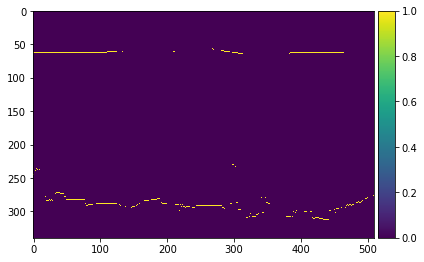

In [17]:
%matplotlib inline
# io.imshow(epi_low_in[0,:,:])
# io.show()
# io.imshow(epi_up_in[0,:,:])
# io.show()
io.imshow(epi_inner_trace[0,:,:])
io.show()

In [18]:
# Determine the lower edge of the spongy mesophyll
c = (img==spongy)
d = (b*c)
m_low = np.argmax(d, axis=1)
        
# Determine the lower edge of the vascular bundle
c = (img==vein)
d = (b*c)
v_low = np.argmax(d, axis=1)

# Determine the lower edge of the epidermis
c = (img==epidermis)
d = (b*c)
e_low = np.argmax(d, axis=1)
e_low = np.maximum(e_low, m_low) # Changes lowest mesophyll pixel to epidermal class
e_low = np.maximum(e_low, v_low) # Changes lowest vein pixel to epidermal class
epi_low = np.zeros(img.shape)
for z in range(0,epi_low.shape[0]):
    for x in range(0,epi_low.shape[2]):
        epi_low[z,e_low[z,x],x] = 1

# Determine the upper edge of epidermis
b2 = np.flip(b,1)
d = (b2*c)
e_up = np.argmax(d, axis=1)
epi_up = np.zeros(img.shape)
for z in range(0,epi_up.shape[0]):
    for x in range(0,epi_up.shape[2]):
        epi_up[z,e_up[z,x],x] = 1

# Combine the lower and upper outer edge of epidermis into a single numpy array
epi_both = epi_up + epi_low

In [19]:
# Combine inner and outer edges of epidermis into single array
epidermis_in_out = np.add(epi_inner_trace,epi_both)

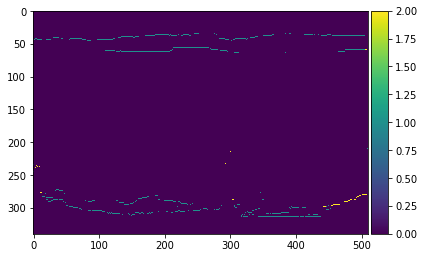

In [24]:
%matplotlib inline
io.imshow(epidermis_in_out[0,:,:])
io.show()
# io.imshow(epidermis_in_out[0,:,:])
# io.show()

In [21]:
list_thing = []
for z in range(0,epi_inner_trace.shape[0]):
    for y in range(0,epi_inner_trace.shape[2]):
        for x in range(0,epi_inner_trace.shape[1]):
            if epi_inner_trace[z,x,y] == 1:
                list_thing.append(x)

distance_list = []
i = 0
while i < len(list_thing)-2:
    hold = list_thing[i+1]-list_thing[i]
    distance_list.append(hold)
    i = i + 2
distance = np.mean(distance_list)
print('Mean mesophyll thickness: '+str(distance)+' pixels')

Mean mesophyll thickness: 214.971682242 pixels


In [22]:
# convert from pixels to uM, scan was taken at 10x mag so 0.636uM/px
print('True mean mesophyll thickness: '+str(distance*0.636)+' microMeters')

True mean mesophyll thickness: 136.721989906 microMeters


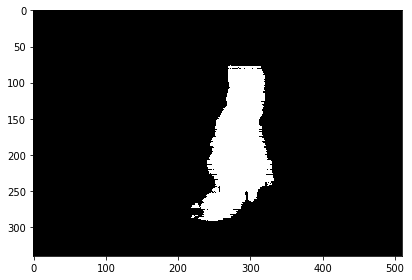

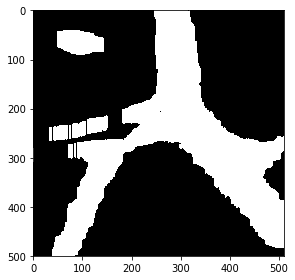

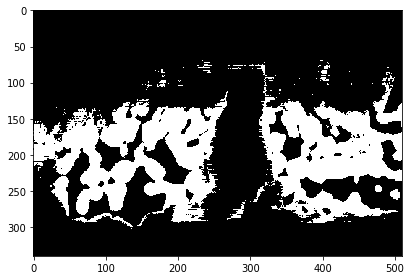

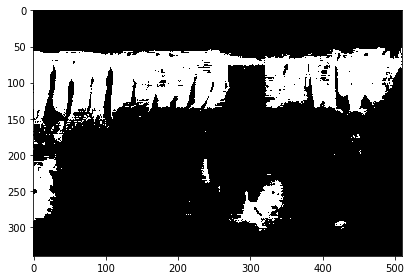

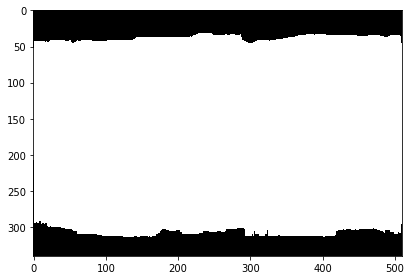

In [30]:
# set up array for each pixel class, to calculate SA
vein_trace = (img==vein)
spongy_trace = (img==spongy)
palisade_trace = (img==palisade)

# Generate a binary stack with the pixels inside the epidermis set equal to 1
# allows us to calculate leaf SA
epi_in = np.zeros(img.shape, dtype=np.uint16)
for y in range(0,epi_in.shape[2]):
    for z in range(0,epi_in.shape[0]):
        epi_in[z,e_up[z,y]:e_low[z,y],y] = 1
epi_in_trace = (epi_in==1)

%matplotlib inline
io.imshow(vein_trace[10,:,:])
io.show()
io.imshow(vein_trace[:,180,:])
io.show()
io.imshow(spongy_trace[10,:,:])
io.show()
io.imshow(palisade_trace[10,:,:])
io.show()
io.imshow(epi_in_trace[10,:,:])
io.show()

In [28]:
vein_vert_faces = marching_cubes_lewiner(vein_trace)
vein_SA = mesh_surface_area(vein_vert_faces[0],vein_vert_faces[1])
print('Vein SA: '+str(vein_SA)+' pixels**2')
spongy_vert_faces = marching_cubes_lewiner(spongy_trace)
spongy_SA = mesh_surface_area(spongy_vert_faces[0],spongy_vert_faces[1])
print('Spongy SA: '+str(spongy_SA)+' pixels**2')
palisade_vert_faces = marching_cubes_lewiner(palisade_trace)
palisade_SA = mesh_surface_area(palisade_vert_faces[0],palisade_vert_faces[1])
print('Palisade SA: '+str(palisade_SA)+' pixels**2')
ias_trace = (img==ias)
ias_vert_faces = marching_cubes_lewiner(ias_trace)
ias_SA = mesh_surface_area(ias_vert_faces[0],ias_vert_faces[1])
print('therefore total mesophyll SA: '+str(ias_SA)+' pixels**2')
# epid_vert_faces = marching_cubes_lewiner(epi_in_trace)
# epid_outer_SA = mesh_surface_area(epid_vert_faces[0],epid_vert_faces[1])
print('Projected abaxial epidermis SA: '+str(img.shape[0]*img.shape[2])+' pixels**2')
print('therefore Sm: '+str(float(ias_SA)/(img.shape[0]*img.shape[2])))

Vein SA: 1084690.5 pixels**2
Spongy SA: 5809700.5 pixels**2
Palisade SA: 4444045.5 pixels**2
therefore total mesophyll SA: 3905827.0 pixels**2
Projected abaxial epidermis SA: 255000 pixels**2
therefore Sm: 15.3169686275


In [29]:
###IGNORE EVERYTHING BELOW THIS POINT###

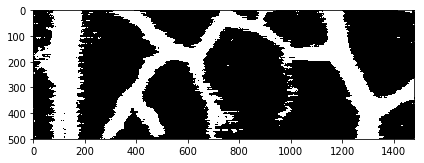

NameError: name 'vein_trace_smooth' is not defined

In [17]:
# figure out some way to calculate vein position, tried skeletonize to get line at central axis
# clearly, did not work
# need some other method, or preprocess (smooth a lot) vein_trace before passing to skeletonize_3d?

# skeleton_vein_trace = skeletonize_3d(vein_trace)
io.imshow(vein_trace[:,185,:])
io.show()

# skeleton_vein_trace = medial_axis(vein_trace)
# io.imshow(skeleton_vein_trace[:,195,:])
# io.show()

# vein_trace_smooth = np.apply_along_axis(dbl_pct_filt, 0, arr = vein_trace)
# io.imshow(vein_trace_smooth[:,185,:])
# io.show()

data = np.array(vein_trace_smooth[:,185,:], copy = True)
skel, distance = medial_axis(data, return_distance=True)
vein_medial_axis = distance * skel
io.imshow(vein_medial_axis)
io.show()



In [ ]:
np.unique(vein_trace)

In [32]:
# Define filters for clipping off artefactual IAS protrusions due to dangling epidermis
def dbl_pct_filt(arr):
    out = percentile_filter(
        percentile_filter(
            arr, 
            size=30, 
            percentile=10),
        size=30,percentile=90)
    return(out)

def min_max_filt(arr):
    out = minimum_filter(
        maximum_filter(arr,1),
        1)
    return out

In [ ]:
io.imshow(vein_trace_smooth[:,170,:])
io.show()

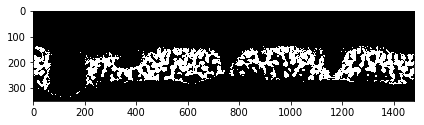

In [26]:
io.imshow(spongy_trace[16,:,:])
io.show()

In [33]:
palisade_trace_minmax = np.apply_along_axis(min_max_filt, 2, arr = palisade_trace)

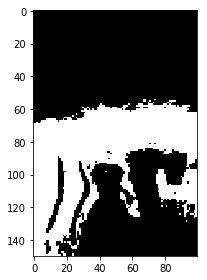

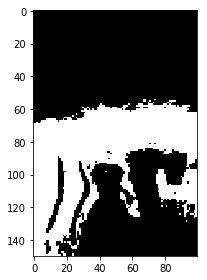

In [34]:
io.imshow(palisade_trace_minmax[16,0:150,700:800])
io.show()
io.imshow(palisade_trace[16,0:150,700:800])
io.show()

In [51]:
img2 = np.array(img, copy=True)
palisade_rmv_parts = np.array(palisade_trace, copy=True)
for i in range(0,palisade_rmv_parts.shape[0]):
    palisade_rmv_parts[i,:,:] = remove_small_objects(palisade_trace[i,:,:], min_size=16, connectivity=10)

# Write an array of just the removed particles
palisade_parts = palisade_trace ^ palisade_rmv_parts

# Replace the small connected epidermal particles (< 800 px^2) with BG value
img2[palisade_parts==1] = bg

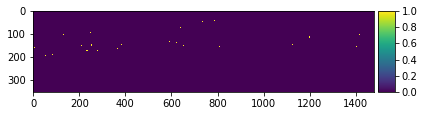

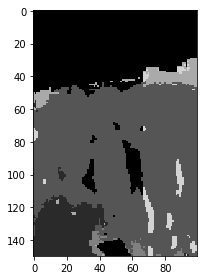

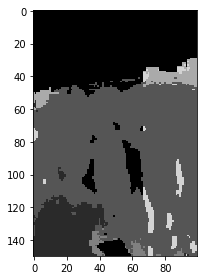

In [50]:
io.imshow(palisade_parts[65,:,:])
io.show()
io.imshow(img2[65,0:150,700:800])
io.show()
io.imshow(img[65,0:150,700:800])
io.show()